# NHL Flames - Event Propensity Model
* Ryan Kazmerik & Joey Lai
* Oct 14, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

### Let's connect to RedShift and run a stored proc to get our dataset:

In [2]:
CLUSTER = "prod-app"
DATABASE = "stlrflames"
LKUPCLIENTID = "36"

In [3]:
df = helpers.get_event_propensity_training_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    start_year=2010,
    end_year=2021
)

df.shape

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

LPNG-VQDG
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/
Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(24850, 17)

In [4]:
df_train = df
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24850 entries, 0 to 24849
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   daysout              24850 non-null  object        
 1   mindaysout           24850 non-null  int64         
 2   maxdaysout           13078 non-null  float64       
 3   dimcustomermasterid  24850 non-null  int64         
 4   recent_openrate      24850 non-null  float64       
 5   recent_clickrate     24850 non-null  float64       
 6   eventdate            24850 non-null  datetime64[ns]
 7   eventname            24850 non-null  object        
 8   inmarket             19593 non-null  object        
 9   distancetovenue      19211 non-null  float64       
 10  tenure               24850 non-null  int64         
 11  did_purchase         24850 non-null  int64         
 12  events_purchased     24850 non-null  int64         
 13  frequency_opponent   24850 non-

In [5]:
df_train.head()

,daysout,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,eventdate,eventname,inmarket,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
0,1 to 3 Days Out,1,4.0,974,0.0,0.0,2022-04-16,20220416 - Arizona Coyotes,False,2689.82,2411,0,242,0.0,0.018519,0.008621,0
1,Day Of,0,1.0,974,0.0,0.0,2022-04-16,20220416 - Arizona Coyotes,False,2689.82,2411,0,242,0.0,0.018519,0.008621,0
2,4 to 7 Days Out,4,8.0,974,0.0,0.0,2022-04-23,20220423 - Vancouver Canucks,False,2689.82,2418,0,244,0.0,0.018182,0.008547,0
3,4 to 7 Days Out,4,8.0,975,0.0,0.0,2017-12-04,20171204 - Philadelphia Flyers,True,23.42,11,0,3,0.0,0.000000,0.333333,0
4,Day Of,0,1.0,975,0.0,0.0,2017-12-09,20171209 - Vancouver Canucks,True,23.42,16,0,4,0.0,0.000000,0.250000,0


### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [6]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.90,
    data_split_shuffle=True,
    categorical_features=[
        "inmarket"
    ],
    date_features=[
        "eventdate"
    ],
    ignore_features=[
        "count_merchowned",
        "dimcustomermasterid",
        "eventname",
        "inmarket",
        "mindaysout",
        "maxdaysout"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_eventday",
        "frequency_opponent",
        "frequency_eventtime",
        "recent_clickrate",
        "recent_openrate",
        "tenure"
    ]
);

In [7]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7707,0.8554,0.7348,0.7923,0.7624,0.5414,0.5429,1.2200


### The top model is performing well, so let's compare it against our test dataset:

In [8]:
final_model = create_model(model_matrix, fold= 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7667,0.8562,0.7321,0.7869,0.7586,0.5333,0.5346
1,0.7783,0.8660,0.7518,0.7943,0.7725,0.5566,0.5574
2,0.7787,0.8566,0.7562,0.7923,0.7739,0.5575,0.5580
3,0.7765,0.8526,0.7312,0.8045,0.7661,0.5530,0.5553
4,0.7649,0.8540,0.7199,0.7920,0.7542,0.5298,0.5320
5,0.7674,0.8548,0.7196,0.7964,0.7561,0.5350,0.5375
6,0.7786,0.8672,0.7491,0.7968,0.7722,0.5573,0.5583
7,0.7500,0.8427,0.7196,0.7669,0.7425,0.5001,0.5010
8,0.7728,0.8518,0.7312,0.7982,0.7633,0.5457,0.5476


### We can also see the correlation between the features and the target variable:

In [9]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
mindaysout,1.00,0.98,0.22,-0.03,-0.04,-0.09,-0.08,0.39,-0.04,0.35,0.36,0.37,-0.01
maxdaysout,0.98,1.00,-0.10,-0.00,0.00,0.03,0.04,-0.13,0.03,0.01,0.00,0.01,0.00
dimcustomermasterid,0.22,-0.10,1.00,-0.02,0.01,-0.18,-0.12,0.64,-0.09,0.20,0.19,0.19,0.03
recent_openrate,-0.03,-0.00,-0.02,1.00,0.52,-0.02,0.01,-0.03,-0.01,-0.03,-0.03,-0.02,0.01
recent_clickrate,-0.04,0.00,0.01,0.52,1.00,-0.02,0.04,0.00,0.02,-0.03,-0.03,-0.02,0.04
distancetovenue,-0.09,0.03,-0.18,-0.02,-0.02,1.00,0.07,-0.26,0.07,-0.08,-0.08,-0.08,-0.02
tenure,-0.08,0.04,-0.12,0.01,0.04,0.07,1.00,-0.18,0.97,-0.06,-0.16,-0.19,0.04
did_purchase,0.39,-0.13,0.64,-0.03,0.00,-0.26,-0.18,1.00,-0.13,0.39,0.40,0.42,0.04
events_purchased,-0.04,0.03,-0.09,-0.01,0.02,0.07,0.97,-0.13,1.00,-0.01,-0.11,-0.15,0.03
frequency_opponent,0.35,0.01,0.20,-0.03,-0.03,-0.08,-0.06,0.39,-0.01,1.00,0.68,0.70,-0.01


### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

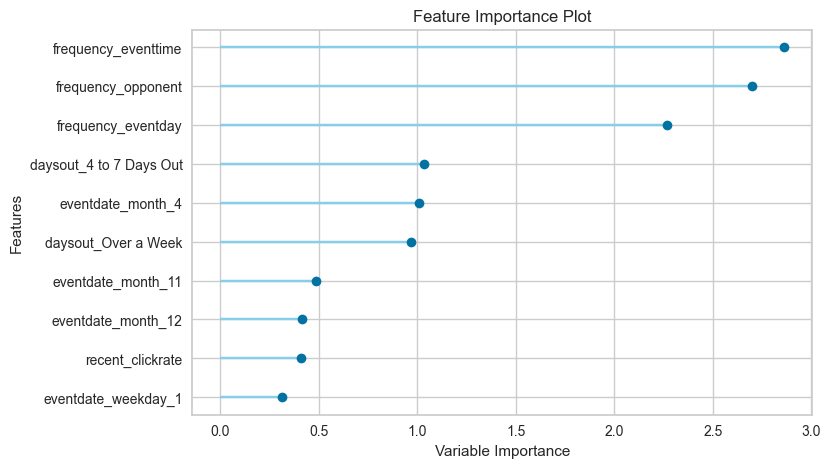

In [10]:
plot_model(final_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

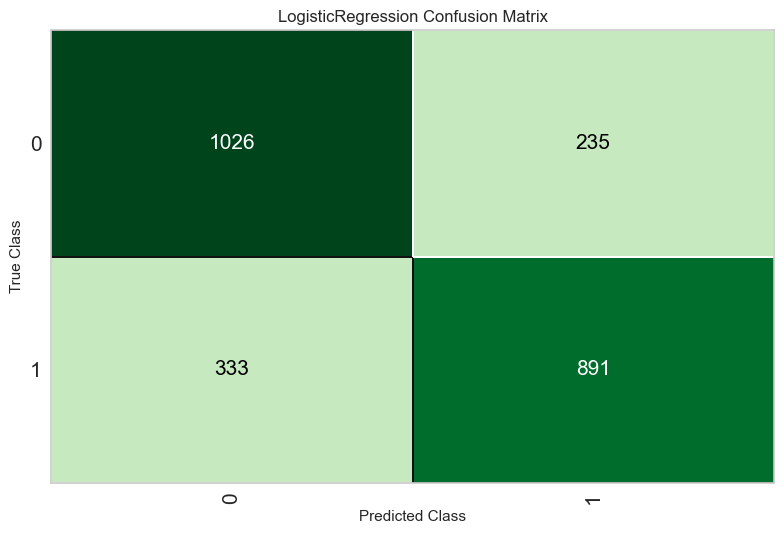

In [11]:
plot_model(final_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

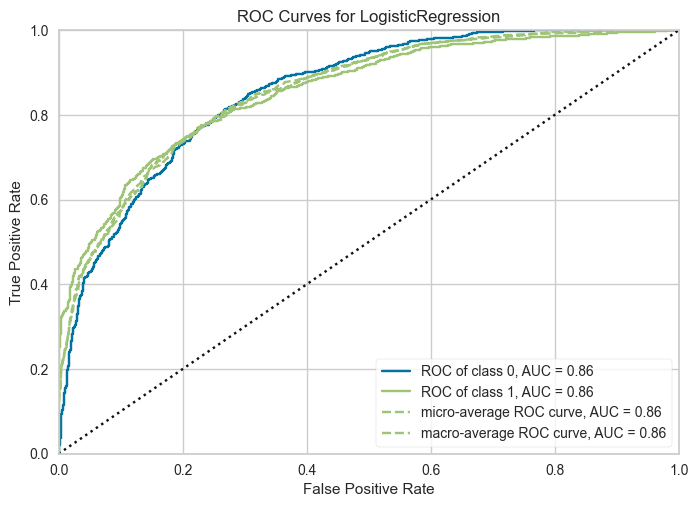

In [12]:
plot_model(final_model, plot='auc')

### Let's load up some real events from previous events to see how the model scores the data:

In [42]:
df_inference = helpers.get_event_propensity_scoring_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    game_date="2022-10-22"
)

df_inference.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(256188, 12)

In [43]:
df_inference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256188 entries, 0 to 256187
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   daysout              256188 non-null  object 
 1   eventdate            256188 non-null  object 
 2   tenure               256188 non-null  int64  
 3   dimcustomermasterid  256188 non-null  int64  
 4   events_purchased     256188 non-null  object 
 5   frequency_opponent   181772 non-null  object 
 6   frequency_eventday   217760 non-null  object 
 7   frequency_eventtime  256188 non-null  object 
 8   inmarket             221744 non-null  object 
 9   distancetovenue      221744 non-null  float64
 10  recent_openrate      54600 non-null   float64
 11  recent_clickrate     54600 non-null   float64
dtypes: float64(3), int64(2), object(7)
memory usage: 23.5+ MB


In [44]:
# RENAMING SOME COLUMNS:
df_inference = df_inference.rename(columns={
    "daysOut": "daysout", "dimCustomerMasterId": "dimcustomermasterid","eventDate": "eventdate","frequency_eventDay":"frequency_eventday","frequency_eventTime":"frequency_eventtime","inMarket":"inmarket","distanceToVenue":"distancetovenue","recent_openRate":"recent_openrate","recent_clickRate":"recent_clickrate"
})

### Let's run the previous scores through the model for predictions:

In [45]:
df_scores = predict_model(final_model, data=df_inference, raw_score=True)
df_scores.head()

,daysout,eventdate,tenure,dimcustomermasterid,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,inmarket,distancetovenue,recent_openrate,recent_clickrate,Label,Score_0,Score_1
0,Day Of,2022-10-22,2584,364095,4.0,0.0000,0.0179,0.0169,True,25.4375,0.0,0.0,0,0.9808,0.0192
1,1 to 3 Days Out,2022-10-22,2584,364095,4.0,0.0000,0.0179,0.0169,True,25.4375,0.0,0.0,0,0.9808,0.0192
2,4 to 7 Days Out,2022-10-22,2584,364095,4.0,0.0000,0.0179,0.0169,True,25.4375,0.0,0.0,0,0.9919,0.0081
3,Over a Week,2022-10-22,2584,364095,4.0,0.0000,0.0179,0.0169,True,25.4375,0.0,0.0,0,0.9431,0.0569
4,Day Of,2022-10-22,2565,2299307,24.0,0.0000,0.0893,0.0975,None,NaN,NaN,NaN,0,0.9729,0.0271


In [46]:
df_scores.frequency_eventday.value_counts()

0.0000    149588
0.0769      4780
0.0909      4460
0.0179      3180
0.2000      2644
           ...  
0.4167         4
0.2121         4
0.3929         4
0.0943         4
0.8000         4
Name: frequency_eventday, Length: 192, dtype: int64

### Included are some metrics on did and did_not purchase:

In [47]:
did_purchase = df_scores["Label"].value_counts()[1]
did_not_purchase = df_scores["Label"].value_counts()[0]
total_rows = df_scores["Label"].count()
purchase_percentage = round((did_purchase / total_rows) * 100, 2)

print(f"Would purchase: {did_purchase}")
print(f"Would not purchase: {did_not_purchase}")
print(f"Purchase percentage: {purchase_percentage}")

Would purchase: 53363
Would not purchase: 202825
Purchase percentage: 20.83


### Here we can see the distribution of fans who would purchase:

<AxesSubplot:xlabel='Score_1', ylabel='Count'>

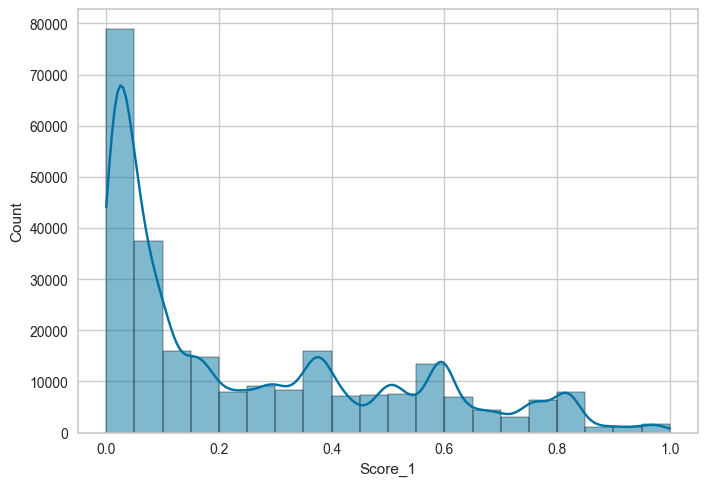

In [48]:
sns.histplot(data=df_scores, x='Score_1', bins= 20, kde=True)

### Let's score a game from our MSSQL scoring proc:

In [21]:
df_inference_2 = pd.read_csv("./data/Flames EP Scoring 2022-10-14.csv")
df_inference_2.head()

,daysOut,eventDate,tenure,dimCustomerMasterId,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,inMarket,distanceToVenue,recent_openRate,recent_clickRate
0,Over a Week,2022-10-18 00:00:00.000,961,126730,2,0.0,0.0,0.039216,NaN,NaN,NaN,NaN
1,Day Of,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0
2,1 to 3 Days Out,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0
3,4 to 7 Days Out,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0
4,Over a Week,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0


In [23]:
# RENAMING SOME COLUMNS:
df_inference_2 = df_inference_2.rename(columns={
    "daysOut": "daysout", "dimCustomerMasterId": "dimcustomermasterid","eventDate": "eventdate","frequency_eventDay":"frequency_eventday","frequency_eventTime":"frequency_eventtime","inMarket":"inmarket","distanceToVenue":"distancetovenue","recent_openRate":"recent_openrate","recent_clickRate":"recent_clickrate"
})

In [24]:
df_scores_2 = predict_model(final_model, data=df_inference_2, raw_score=True)
df_scores_2.head()

,daysout,eventdate,tenure,dimcustomermasterid,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,inmarket,distancetovenue,recent_openrate,recent_clickrate,Label,Score_0,Score_1
0,Over a Week,2022-10-18 00:00:00.000,961,126730,2,0.0,0.0,0.039216,NaN,NaN,NaN,NaN,0,0.7408,0.2592
1,Day Of,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0,0,0.7299,0.2701
2,1 to 3 Days Out,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0,0,0.7299,0.2701
3,4 to 7 Days Out,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0,0,0.8663,0.1337
4,Over a Week,2022-10-18 00:00:00.000,214,7102,1,0.0,0.0,0.071429,NaN,NaN,1.0,0.0,1,0.4667,0.5333


In [25]:
did_purchase = df_scores_2["Label"].value_counts()[1]
did_not_purchase = df_scores_2["Label"].value_counts()[0]
total_rows = df_scores_2["Label"].count()
purchase_percentage = round((did_purchase / total_rows) * 100, 2)

print(f"Would purchase: {did_purchase}")
print(f"Would not purchase: {did_not_purchase}")
print(f"Purchase percentage: {purchase_percentage}")

Would purchase: 9950
Would not purchase: 207802
Purchase percentage: 4.57


<AxesSubplot:xlabel='Score_1', ylabel='Count'>

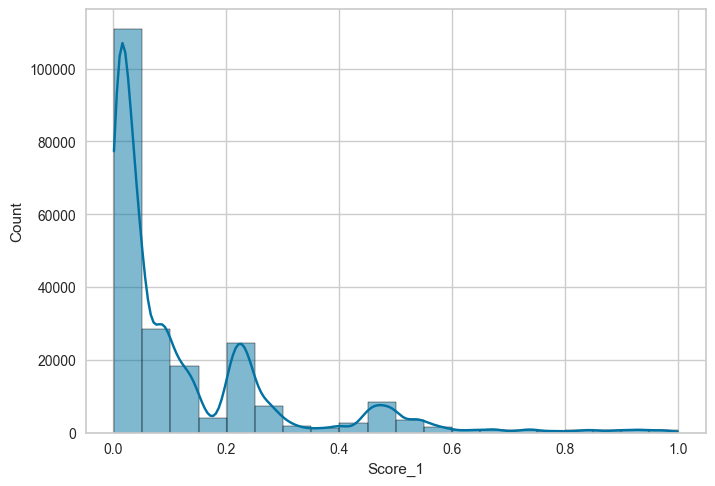

In [26]:
sns.histplot(data=df_scores_2, x='Score_1', bins= 20, kde=True)

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?